# Simulated grid cells, head-direction cells, and conjunctive cells.
* We use simulated grid cells from "Toroidal topology of population activity in grid cells" (Gardner et al, 2022). The specific simulation model is based on "Recurrent inhibitory circuitry as a mechanism for grid formulation" (Couey et al, 2013).
* We simulated head-direction cells using tuning curves.
* The firing rates of conjunctive cells were computed as the minimum of the firing rates of a grid cell and a head-direction cell.
* Please use `environment.yml` file to create a conda environment. The use of `numba` library in `utils.py` requires specific versions of packages. 

In [ ]:
import sys

sys.path.append("../../src/")

from utils import * # This code is from Gardner et al, 2022
from simulations import *
import random

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import os
from scipy import *
import scipy.io
from julia.api import Julia
from simulations import *

In [3]:
def add_unreliable_intervals_default(rates, p, baseline, reliability_interval = 10):
    """
    For each neuron, add unreliable intervals at which the neurons just fire at baseline. 
    For each unit of "reliability_interval", sample from a Bernoulli distribution to decide whether the neuron's firing rate
    should be decreased to baseline
    
    --- input ---
    rates: (array) of neuron firing rates predicted by the neural network. 
        Has shape (n_timebins, n_neurons)
    p: (float) probability "p" of the Bernoulli distribution
    baseline: (float) baseline firing rate
    reliability_interval: (int) units (in seconds) for unreliability of neurons 
    
    --- output ---
    adjusted_rates: (array) of neuron firing rates in which specific intervals are adjusted to have baseline firing rates 
    """
    
    n_neurons = rates.shape[1]
    n_frames = rates.shape[0]
    adjusted_rates = rates.copy()
    
    # check that the `reliability_interval` divides the number of timebins 
    if n_frames % reliability_interval != 0:
        print("argument `reliability_interval` should divide the number of frames.")
        return None
    else:
        m = int(n_frames / reliability_interval)
        for i in range(n_neurons):
            binomial = np.random.binomial(1, p, m)
            binomial = np.repeat(binomial, reliability_interval, axis = 0)

            for f in range(n_frames):
                if binomial[f] == 0:
                    adjusted_rates[f,i] = baseline
        return adjusted_rates
    

# 1. Run Couey simulation
* The code for simulating grid cells comes from "Toroidal topology of population activity in grid cells" (Gardner et al, 2022).
* It simulates the firing rates of 2464 grid cells. 
* For computational efficiency, we randomly select 200 cells for the pure grid cells. 

In [ ]:
#### Couey
xx,yy,__,__ = load_pos('R','OF','day1',bSpeed = False)

dxx =  xx[:100000]#gaussian_filter1d(xx,10)
dyy =  yy[:100000]#gaussian_filter1d(yy,10)
speeds = np.zeros(len(dxx))
speeds[1:] =np.sqrt(np.square(dxx[1:]-dxx[:-1]) + np.square(dyy[1:]-dyy[:-1]))*1000
speeds[0] = speeds[1]
angs = np.zeros(len(dxx))
angs[1:] = np.arctan2(dyy[1:]-dyy[:-1],dxx[1:]-dxx[:-1])
angs[0] = angs[1]
posx = xx[np.arange(0,180000,2)]
posy = yy[np.arange(0,180000,2)]
post = np.arange(0,180000,2)/100

#xx,yy = xx[np.arange(0,15000,10)],yy[np.arange(0,15000,10)]
dxx =  xx[:100000]#gaussian_filter1d(xx,10)
dyy =  yy[:100000]#gaussian_filter1d(yy,10)
#dxx,dyy = dxx[np.arange(0,50000,1)],dyy[np.arange(0,50000,1)]
#num_steps = len(dxx)
speeds = np.zeros(len(dxx))
speeds[1:] =np.sqrt(np.square(dxx[1:]-dxx[:-1]) + np.square(dyy[1:]-dyy[:-1]))*1000
speeds[0] = speeds[1]
angs = np.zeros(len(dxx))
angs[1:] = np.arctan2(dyy[1:]-dyy[:-1],dxx[1:]-dxx[:-1])
angs[0] = angs[1]
posx = xx[np.arange(0,180000,2)]
posy = yy[np.arange(0,180000,2)]
post = np.arange(0,180000,2)/100

post = post[np.isfinite(posx)]
posy = posy[np.isfinite(posx)]
posx = posx[np.isfinite(posx)]
post = post[np.isfinite(posy)]
posx = posx[np.isfinite(posy)]
posy = posy[np.isfinite(posy)]
post *= 1000

side = max(max(posx)-min(posx), max(posy)-min(posy))
posx *= 1./side
posy *= 1./side
posx -= min(posx)
posy -= min(posy)

tnew = np.arange(0, 599000, 1)
posx = np.interp(tnew, post, posx)
posy = np.interp(tnew, post, posy)
post = tnew

#Get angles and velocities
angs = np.zeros(len(post))
angs[:-1] = np.arctan2(posy[1:]-posy[:-1], posx[1:]-posx[:-1])
angs[-1] = angs[-2]
speeds = 1000.*np.sqrt((posx[1:]-posx[:-1])**2+(posy[1:]-posy[:-1])**2)
nums = len(speeds)
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import os
from scipy import *
import scipy.io

numbumps = 4 
# parameters of the model
extinp = 1.
alpha = 0.15
ell = 2.
inh = -0.02
R  = 15.
Nx = 28
Ny = 44

if(numbumps==4):
    Nx*=2
if(numbumps==8):
    Nx*=2
    Ny*=2
NG=Nx*Ny 

### MAKE CONNECTIVITY WITH AN OFFSET RELATIVE TO PREFERRED DIRECTION
theta = zeros([Nx,Ny])
theta[0:Nx:2,0:Ny:2] = 0
theta[1:Nx:2,0:Ny:2] = 1
theta[0:Nx:2,1:Ny:2] = 2
theta[1:Nx:2,1:Ny:2] = 3
theta = 0.5*pi*theta
theta = ravel(theta)
xes = zeros([Nx,Ny])
yes = zeros([Nx,Ny])
for x in range(Nx):
    for y in range(Ny):
        xes[x,y] = x
        yes[x,y] = y
xes = ravel(xes)
yes = ravel(yes)
Rsqrd = R**2
W = zeros([NG,NG])
for xi in range(Nx):
    xdiffA = abs(xes-xi-ell*cos(theta))
    xdiffB = Nx-xdiffA
    xdiffA = xdiffA**2
    xdiffB = xdiffB**2
    for y in range(Ny):
        n = xi*Ny+y
        ydiffA = abs(yes-y-ell*sin(theta))
        ydiffB = Ny-ydiffA
        ydiffA = ydiffA**2
        ydiffB = ydiffB**2
        d = xdiffA+ydiffA
        W[d<Rsqrd,n] += inh
        d = xdiffB+ydiffA
        W[d<Rsqrd,n] += inh
        d = xdiffA+ydiffB
        W[d<Rsqrd,n] += inh
        d = xdiffB+ydiffB
        W[d<Rsqrd,n] += inh
xes=0
yes=0
N = NG

S = (rand(Nx*Ny) > 0.1)*1.0
for t in range(2000):
    S = S + 0.1*(-S + maximum((extinp+np.matmul(S,W)),0.))
    S[S<0.00001] = 0.

maxS = max(np.ravel(S))
minx = min([min(posy),min(posx)])
maxx = max([max(posy),max(posx)])
whichn = np.arange(len(S))#random.sample(np.arange(len(S)), 100)
nodes1 = np.zeros([len(whichn), nums])

fig = plt.figure(13)
plt.plot([],[],'-')
#print animation.writers.avail

for t in range(0, nums):
    S = S + 0.1*(-S + np.maximum((extinp+np.matmul(S,W)+alpha*speeds[t]*np.cos(angs[t]-theta)),0.))
    if(np.mod(t,10)==0):
        S[S<0.0001] = 0.
    nodes1[:,t] = S#[]#>0.3*maxS ##some fake spikes
    if(np.mod(t,5000)==0 and t>2):
        print('%2.2f percent done'%(float(t)*100/float(nums)))
from scipy.stats import binned_statistic_2d, pearsonr
num_neurons = len(nodes1[:,0])
inds = np.arange(num_neurons)
np.random.shuffle(inds)
for i in inds[:5]:
    mtot, x_edge, y_edge, circ = binned_statistic_2d(posx[:t],posy[:t], nodes1[i,:t], 
        statistic='mean', bins=50, range=None, expand_binnumbers=True)
    plt.figure()
    plt.imshow(mtot)

# 2. Get firing rates of grid cells

In [6]:

#time_cutoff = nodes1.shape[1]
time_cutoff = 100000 # limiting to the first 100,000 timebins
simulated_raster = nodes1[:, :time_cutoff]

Select pure grid cells

In [10]:
n_grid = 200
n_cells = nodes1.shape[0]

# select random pure grid cells
idx_range = list(range(n_cells))
# shuffle the indices
random.shuffle(idx_range)
grid_idx = idx_range[:n_grid]

grid_rates = simulated_raster[grid_idx, : ]

In [12]:
# save grid cell rate
hf = h5py.File('simulated_data/grid_rate.h5', 'w')
hf.create_dataset('raster', data = grid_rates)
hf.close()

In [6]:
# print size of grid cell rate matrix
f = h5py.File('simulated_data/grid_rate.h5','r')
grid_rate = f["raster"][()]
f.close()

print("Shape of grid rate matrix:")
print(grid_rate.shape)

Shape of grid rate matrix:
(200, 100000)


Compute dissimilarity matrix among grid cells

In [14]:
# compute dissimilarity matrix among grid cells
!python3 ../../src/compute_similarity_multiprocessing.py simulated_data/grid_rate.h5 100 simulated_data/grid_dissimilarity.h5


Computation time for 200 neurons: 693.58


# 3. Simulate head direction cells
* Use the head direction angle from the experiments to generate simulated head-direction cells.

Adjust head direction angle range from $(- \pi, \pi)$ to $(0, 2 \pi)$.

In [11]:
angs_adjust = angs + math.pi
angs_adjust = angs_adjust[:time_cutoff]

Specify tuning curve

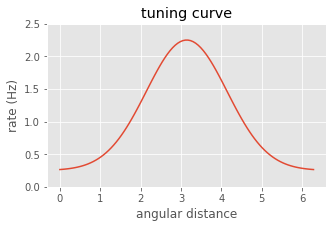

In [12]:
# specify tuning curve
%matplotlib inline
theta_preferred = math.pi
R_preferred = 2
C = 0.25
sigma = 1

# example orientation-tuning with pi/2 as the preferred orientation
x = np.linspace(0, 2* math.pi, 100)
tc = [tuning_curve(theta_preferred, C, R_preferred, sigma, t, size = 2 * math.pi) for t in x]

fig, ax = plt.subplots(figsize = (5,3))
ax.plot(x, tc)

ax.set_title("tuning curve")
ax.set_ylabel("rate (Hz)")
ax.set_xlabel("angular distance")
ax.set_ylim((0, 2.5))
plt.show()

In [13]:
# generate head-directions
n_neurons = 200

# orientations
neurons_HD = np.random.uniform(low=0, high=2 * math.pi, size=n_neurons)

# R_preferred
R_preferred = [2 * 0.2] * n_neurons

# sigma
sigma = [0.4] * n_neurons

# baseline rate
C = [0] * n_neurons


In [14]:
# get orientation-sensitive neurons firing rate for training data
rates_HD = compute_firing_rates(angs_adjust, neurons_HD, C, R_preferred, sigma, size = 2 * math.pi)

In [29]:
# add unreliable intervals
rates_HD = add_unreliable_intervals_default(rates_HD[0:99900,:], 0.5, 0, 100) # we ussed 99900 because there are 100000 timebins

In [31]:
# save HD rate
hf = h5py.File('simulated_data/HD_rate.h5', 'w')
hf.create_dataset('raster', data = rates_HD.T)
hf.close()

Compute dissimilarity matrix among HD firing rates

In [32]:
# compute distance matrix
!python3 ../../src/compute_similarity_multiprocessing.py simulated_data/HD_rate.h5 100 simulated_data/HD_dissimilarity.h5

Computation time for 200 neurons: 705.69


# 4. Simulate conjunctive cells
* take random samples of grid cells (distinct from the pure grid cells)
* for each selected grid cell, choose a random preferred direction for HD cells
* take a conjunction of the grid cell and the HD cell firing rates 


In [18]:
# specify number of conjunctive cells 
n_conj = 10

conj_idx = idx_range[n_grid:n_grid + n_conj]
conj_grid = simulated_raster[conj_idx, :]

In [19]:
# make the "rates" of orientation-sensitive neurons comparable
# for each conjunctive cell (conj_idx), assign a randomly selected orientation
# generate head-directions

# orientations
conj_HD = np.random.uniform(low=0, high=2 * math.pi, size = n_conj)

# R_preferred
R_preferred = [2 * 0.2] * n_conj

# sigma
sigma = [0.4] * n_conj

# baseline rate
C = [0] * n_conj


In [20]:
# get orientation-sensitive neurons firing rate for training data
rates_conj_HD = compute_firing_rates(angs_adjust, conj_HD, C, R_preferred, sigma, size = 2 * math.pi)

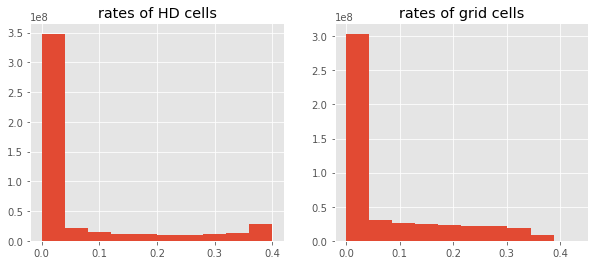

In [36]:
fig, ax = plt.subplots(ncols = 2, figsize = (10, 4))
ax[0].hist(rates_conj_HD.ravel())
ax[0].set_title("rates of HD cells")
ax[1].hist(conj_grid.ravel())
ax[1].set_title("rates of grid cells")
plt.show()

In [21]:
conj_cells = minimum(conj_grid, rates_conj_HD.T)

/Users/irisyoon/opt/anaconda3/envs/GridCellTorus/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: scipy.minimum is deprecated and will be removed in SciPy 2.0.0, use numpy.minimum instead
  """Entry point for launching an IPython kernel.


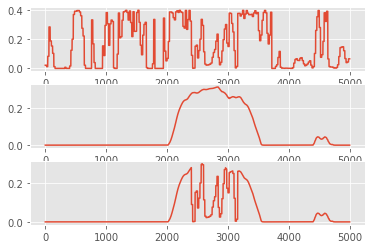

In [39]:
idx = 0
start = 90000
end = start + 5000
fig, ax = plt.subplots(nrows = 3)
ax[0].plot(rates_conj_HD.T[idx,start:end])
ax[1].plot(conj_grid[idx, start:end])
ax[2].plot(conj_cells[idx, start:end])
plt.show()

In [40]:

# save conjunctive cell rates
hf = h5py.File('figures/example_HD_grid_conj_rates.h5', 'w')
hf.create_dataset('grid_rates', data = conj_grid)
hf.create_dataset('HD_rates', data = rates_conj_HD.T)
hf.create_dataset('conj_rates', data = conj_cells)
hf.close()


Save rasters
* make sure that the rows correspond to cells

In [43]:
# check conj_cells shape
conj_cells = conj_cells[:,:100000] 

In [45]:

# save conjunctive cell rates
hf = h5py.File('simulated_data/conj_rate.h5', 'w')
hf.create_dataset('raster', data = conj_cells)
hf.close()


# 5. Compute cross-system dissimilarity matrices


In [46]:
# dissimilarity among conjunctive cells
!python3 ../../src/compute_similarity_multiprocessing.py simulated_data/conj_rate.h5 100 simulated_data/conj_dissimilarity.h5

Computation time for 800 neurons: 11576.25


In [ ]:
# dissimilarity between conjunctive cells and HD cells
!python3 ../../src/cross_similarity_multiprocessing.py simulated_data/conj_rate.h5 simulated_data/HD_rate.h5 100 simulated_data/conj_HD_rate_dissimilarity.h5

*** This script computes the cross-similarity matrix between two rasters *** 


In [25]:
# dissimilarity between conjunctive cells and grid cells 
!python3 ../../src/cross_similarity_multiprocessing.py simulated_data/conj_rate.h5 simulated_data/grid_rate.h5 100 simulated_data/conj_grid_rate_dissimilarity.h5

/bin/bash: -c: line 0: unexpected EOF while looking for matching ``'
/bin/bash: -c: line 1: syntax error: unexpected end of file
